In [ ]:
import glob
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/emotion_recognizer/

In [19]:
import sys, os
import numpy
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from __future__ import division

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json

import itertools
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [20]:
dataset = pd.read_csv('data_operations/fer2013.csv')
#width, height
w, h = 48, 48 
X = []

#getting features for training from dataset
for i in dataset['pixels'].tolist():
    x_val = [int(xp) for xp in i.split(' ')]
    x_val = np.asarray(x_val).reshape(w, h)
    X.append(x_val.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting emotion labels for training from dataset
y = pd.get_dummies(dataset['emotion']).to_numpy()

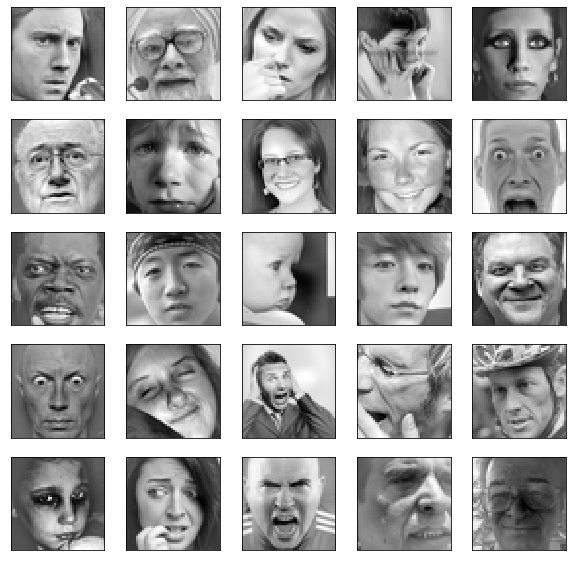

In [21]:
#saving them using numpy

np.save('model/x_hypo', X) #data
np.save('model/y_hypo', y) #label

x = np.load('model/x_hypo.npy')
y = np.load('model/y_hypo.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

#Verify the data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()


In [22]:
#@title Default title text
#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test sample 
np.save('model/X_test', X_test)
np.save('model/y_test', y_test)

#desinging the CNN

#stack for layers
model = Sequential() 

#input layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(w, h, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

#hidden layer1
model.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

#hidden layer2
model.add(Conv2D(2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

#hidden layer3
model.add(Conv2D(2*2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

#hidden layer4
model.add(Conv2D(2*2*2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

#dense layer / classification
model.add(Flatten())

model.add(Dense(2*2*2*2*64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*2*64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_14 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_15 (Batc (None, 23, 23, 128)      

In [23]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [24]:
#training the model
history = model.fit(np.array(X_train), np.array(y_train),
          batch_size=64,
          epochs=100,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

Epoch 1/100
455/455 [==============================] - 32s 64ms/step - loss: 2.1586 - accuracy: 0.2020 - val_loss: 1.8311 - val_accuracy: 0.2594
Epoch 2/100
455/455 [==============================] - 29s 63ms/step - loss: 1.8461 - accuracy: 0.2427 - val_loss: 1.8028 - val_accuracy: 0.2594
Epoch 3/100
455/455 [==============================] - 29s 63ms/step - loss: 1.8293 - accuracy: 0.2479 - val_loss: 1.7637 - val_accuracy: 0.2780
Epoch 4/100
455/455 [==============================] - 28s 63ms/step - loss: 1.7934 - accuracy: 0.2664 - val_loss: 1.7214 - val_accuracy: 0.2848
Epoch 5/100
455/455 [==============================] - 28s 63ms/step - loss: 1.6777 - accuracy: 0.3195 - val_loss: 1.4771 - val_accuracy: 0.4084
Epoch 6/100
455/455 [==============================] - 28s 63ms/step - loss: 1.5625 - accuracy: 0.3885 - val_loss: 1.4045 - val_accuracy: 0.4365
Epoch 7/100
455/455 [==============================] - 29s 63ms/step - loss: 1.4771 - accuracy: 0.4178 - val_loss: 1.4000 - val_ac

In [25]:
#saving the  model

fer_json = model.to_json()
with open("model/fer.json", "w") as json_file: json_file.write(fer_json)
model.save_weights("model/model.h5")

101/101 - 1s - loss: 1.2093 - accuracy: 0.6570
0.656965970993042


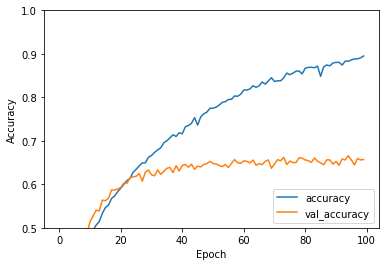

In [26]:
#evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=2)
print(test_acc)

In [27]:
#loading the model
json_file = open('model/fer.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("model/model.h5")

true_y=[]
pred_y=[]

x_test_acc = np.load('model/X_test.npy')
y_test_acc = np.load('model/y_test.npy')

y_tmp= model.predict(x_test_acc)
yh = y_tmp.tolist()
yt = y.tolist()


In [28]:
#setting image resizing parameters
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#loading image
image = cv2.resize(cv2.imread('test_pictures/test.jpg'), ( 225, 225))

full_size_image = cv2.imread('test_pictures/test.jpg')
print("Image Loaded")
gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
face = cv2.CascadeClassifier('data_operations/haarcascade_frontalface_default.xml')
faces = face.detectMultiScale(gray, 1.3  , 10)

emotion = ""

#detecting faces
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (255, 0, 0), 5)
        #predicting the emotion
        yhat= model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 0, 0), 5, cv2.LINE_AA)
        emotion = labels[int(np.argmax(yhat))]
        print("Emotion: "+labels[int(np.argmax(yhat))])

Image Loaded
Emotion: Happy


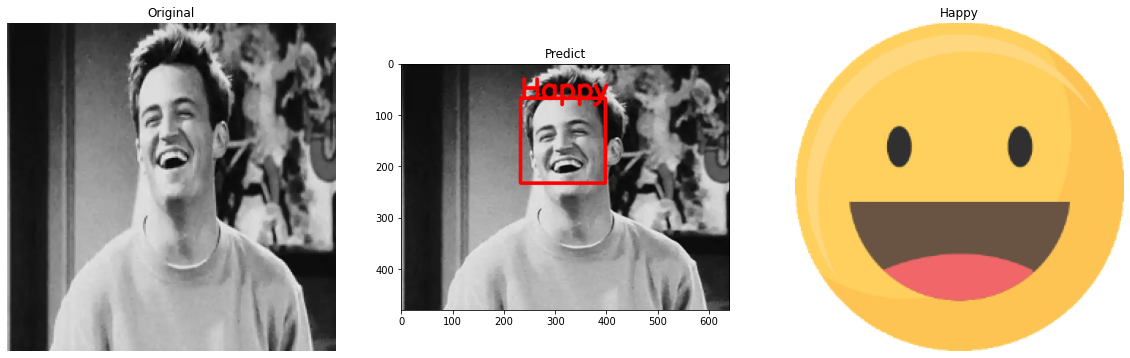

In [29]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1,3,1)
plt.title('Original')
plt.axis('off')
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

ax2 = fig.add_subplot(1,3,2)
plt.title('Predict')
ax2.imshow(full_size_image)

ax3 = fig.add_subplot(1,3,3)
plt.title(str(emotion))
plt.axis('off')
em = cv2.resize(cv2.imread('emojis/'+ emotion + '.png'), (225, 225))
ax3.imshow(cv2.cvtColor(em, cv2.COLOR_BGR2RGB))

plt.show()

In [35]:
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np

json_file = open('model/fer.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("model/model.h5")

true_y=[]
pred_y=[]
x_acc = np.load('model/X_test.npy')
y_acc = np.load('model/y_test.npy')

y_tmp = model.predict(x_acc)
yh = y_tmp.tolist()
yt = y_acc.tolist()
count = 0

for i in range(len(y_acc)):
    yy = max(yh[i])
    yyt = max(yt[i])
    pred_y.append(yh[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y_acc))*100

np.save('model/conf_true_y', true_y)
np.save('model/conf_pred_y', pred_y)
print("Accuracy:"+str(acc)+"%")

Accuracy:64.25188074672612%


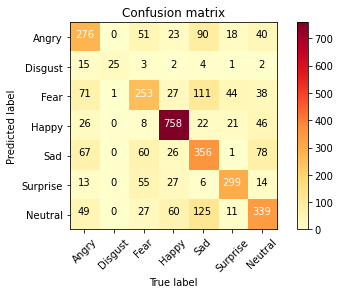

In [46]:
y_true = np.load('model/conf_true_y.npy')
y_pred = np.load('model/conf_pred_y.npy')
cm = confusion_matrix(y_true, y_pred)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrRd)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 5
for i, j in itertools.product(range(cm.shape[1]), range(cm.shape[0])):
    plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()